<a href="https://colab.research.google.com/github/baixabhi/Time-Series-Analysis-and-LSTM-Forecasting/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
!pip install netCDF4
!pip install cartopy
!pip install metpy

In [70]:
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from metpy.cbook import get_test_data
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [71]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
df = xr.open_dataset("/content/drive/MyDrive/ML_PROJECTS/cs_itf.nc")
print(df)

<xarray.Dataset>
Dimensions:  (DEPTH: 1, TAXIS: 10227)
Coordinates:
  * DEPTH    (DEPTH) float64 15.0
  * TAXIS    (TAXIS) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-12-31
Data variables:
    CS_ITF   (TAXIS, DEPTH) float64 ...
Attributes:
    history:      PyFerret V7.5 (optimized) 19-Jan-22
    Conventions:  CF-1.6


In [73]:
print(df['CS_ITF'])

<xarray.DataArray 'CS_ITF' (TAXIS: 10227, DEPTH: 1)>
[10227 values with dtype=float64]
Coordinates:
  * DEPTH    (DEPTH) float64 15.0
  * TAXIS    (TAXIS) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-12-31
Attributes:
    long_name:  CS[X=105:118@AVE,Y=-9:-15@AVE,GT=TGT]
    history:    From ISRO_CURRENT_TOT_1993_2020_NIO


In [74]:
print(df['DEPTH'])

<xarray.DataArray 'DEPTH' (DEPTH: 1)>
array([15.])
Coordinates:
  * DEPTH    (DEPTH) float64 15.0
Attributes:
    units:          meters
    axis:           Z
    point_spacing:  even
    standard_name:  altitude


In [75]:
print(df['TAXIS'])

<xarray.DataArray 'TAXIS' (TAXIS: 10227)>
array(['1993-01-01T00:00:00.000000000', '1993-01-02T00:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * TAXIS    (TAXIS) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-12-31
Attributes:
    axis:           T
    time_origin:    15-JAN-1901
    standard_name:  time


In [76]:
print(df.attrs)

{'history': 'PyFerret V7.5 (optimized) 19-Jan-22', 'Conventions': 'CF-1.6'}


In [77]:
data_var = df.metpy.parse_cf('CS_ITF')
print(data_var)

<xarray.DataArray 'CS_ITF' (TAXIS: 10227, DEPTH: 1)>
[10227 values with dtype=float64]
Coordinates:
  * DEPTH    (DEPTH) float64 15.0
  * TAXIS    (TAXIS) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-12-31
Attributes:
    long_name:  CS[X=105:118@AVE,Y=-9:-15@AVE,GT=TGT]
    history:    From ISRO_CURRENT_TOT_1993_2020_NIO


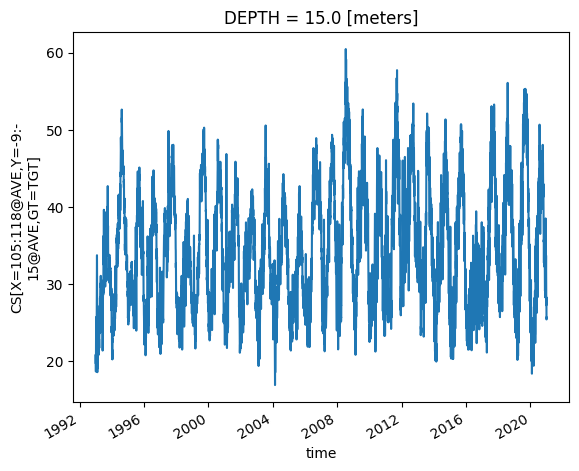

In [78]:
df['CS_ITF'].plot()
plt.show()

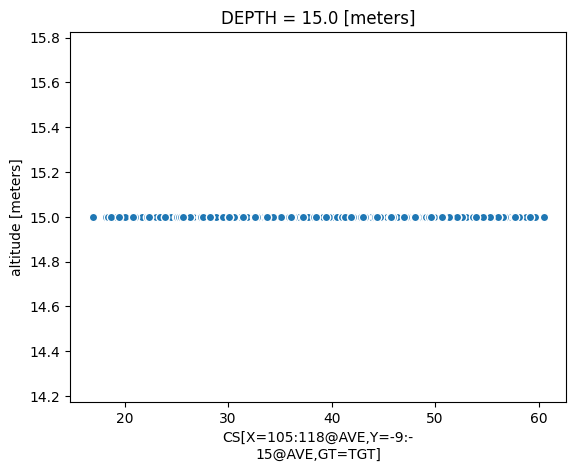

In [79]:
xr.plot.scatter(df, x="CS_ITF", y="DEPTH")

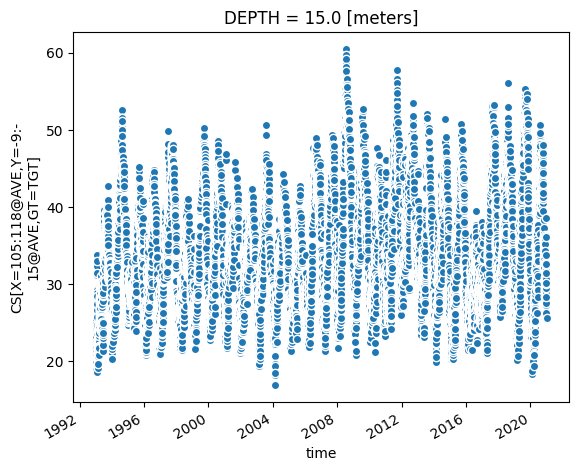

In [80]:
xr.plot.scatter(df, x="TAXIS", y="CS_ITF")

In [81]:
mean_data = df['CS_ITF'].mean(dim='TAXIS')
mean_data

<xarray.DataArray 'CS_ITF' (DEPTH: 1)>
array([34.39170146])
Coordinates:
  * DEPTH    (DEPTH) float64 15.0

In [82]:
scaled_data = df['CS_ITF'] * 10
scaled_data

<xarray.DataArray 'CS_ITF' (TAXIS: 10227, DEPTH: 1)>
array([[197.9729346 ],
       [208.6075493 ],
       [206.71833701],
       ...,
       [262.81310286],
       [254.20667312],
       [256.64763759]])
Coordinates:
  * DEPTH    (DEPTH) float64 15.0
  * TAXIS    (TAXIS) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-12-31

In [83]:
mean_depth = df.mean(dim='TAXIS')

In [84]:
mean_depth

<xarray.Dataset>
Dimensions:  (DEPTH: 1)
Coordinates:
  * DEPTH    (DEPTH) float64 15.0
Data variables:
    CS_ITF   (DEPTH) float64 34.39

In [85]:
y = data_var.DEPTH

In [86]:
x = data_var.TAXIS

In [87]:
im_data = data_var.isel(TAXIS=0)
im_data

<xarray.DataArray 'CS_ITF' (DEPTH: 1)>
array([19.797293])
Coordinates:
  * DEPTH    (DEPTH) float64 15.0
    TAXIS    datetime64[ns] 1993-01-01
Attributes:
    long_name:  CS[X=105:118@AVE,Y=-9:-15@AVE,GT=TGT]
    history:    From ISRO_CURRENT_TOT_1993_2020_NIO

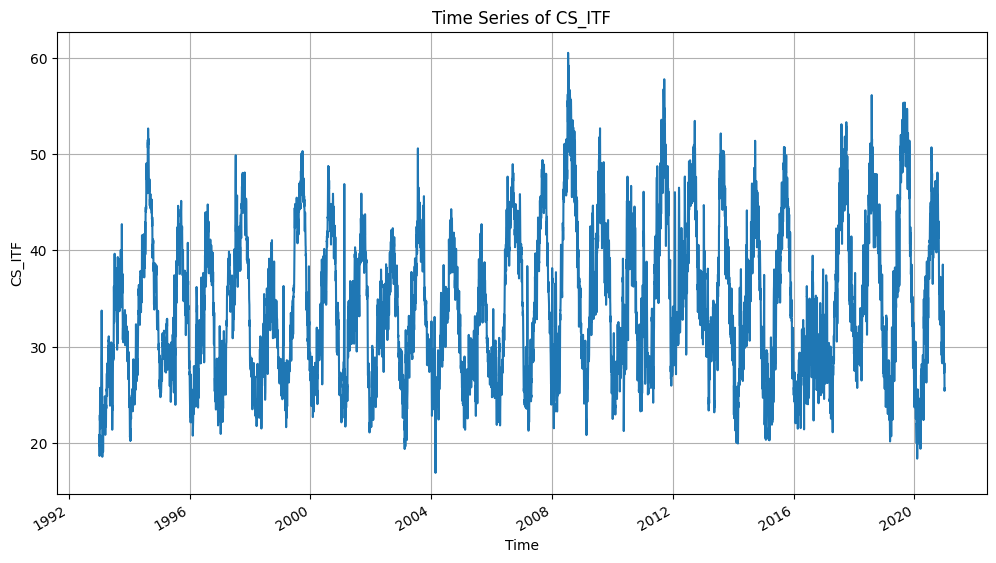

In [88]:
plt.figure(figsize=(12, 6))
df['CS_ITF'].plot()
plt.title('Time Series of CS_ITF')
plt.xlabel('Time')
plt.ylabel('CS_ITF')
plt.grid(True)
plt.show()

In [89]:
yearly_mean = df['CS_ITF'].groupby('TAXIS.year').mean(dim='TAXIS')
print(yearly_mean)

<xarray.DataArray 'CS_ITF' (year: 28, DEPTH: 1)>
array([[29.53041846],
       [35.4725358 ],
       [32.78488294],
       [31.41184808],
       [36.65189315],
       [29.80044105],
       [35.23058072],
       [34.17891101],
       [33.13376261],
       [32.70588339],
       [32.90171141],
       [32.45959988],
       [29.94920231],
       [35.71233305],
       [34.99589667],
       [40.40607748],
       [36.48071299],
       [32.54007594],
       [37.97415242],
       [38.96992299],
       [36.23790602],
       [34.18074217],
       [34.87504971],
       [28.44441521],
       [36.69465675],
       [37.78717586],
       [37.84750554],
       [33.61279478]])
Coordinates:
  * DEPTH    (DEPTH) float64 15.0
  * year     (year) int64 1993 1994 1995 1996 1997 ... 2016 2017 2018 2019 2020
Attributes:
    long_name:  CS[X=105:118@AVE,Y=-9:-15@AVE,GT=TGT]
    history:    From ISRO_CURRENT_TOT_1993_2020_NIO


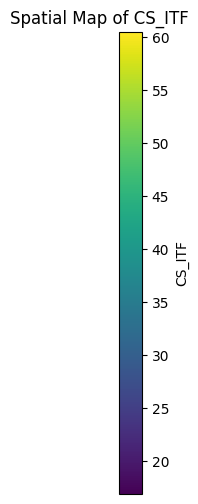

In [90]:
lon = df['DEPTH'].values  # Assuming 'DEPTH' corresponds to longitude
lat = df['TAXIS'].values  # Assuming 'TAXIS' corresponds to latitude
data = df['CS_ITF'].values

plt.figure(figsize=(5, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap='viridis')
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.BORDERS)  # Corrected line
plt.colorbar(label='CS_ITF')
plt.title('Spatial Map of CS_ITF')
plt.show()

In [91]:
time_series = df['CS_ITF'].values.reshape(-1, 1)

In [92]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series)

In [93]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [94]:
sequence_length = 10

X, y = create_sequences(scaled_data, sequence_length)

In [95]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [96]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [97]:
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)

loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

Epoch 1/100
256/256 [==============================] - 4s 9ms/step - loss: 0.0113
Epoch 2/100
256/256 [==============================] - 3s 11ms/step - loss: 0.0021
Epoch 3/100
256/256 [==============================] - 3s 13ms/step - loss: 0.0018
Epoch 4/100
256/256 [==============================] - 3s 11ms/step - loss: 0.0016
Epoch 5/100
256/256 [==============================] - 3s 10ms/step - loss: 0.0014
Epoch 6/100
256/256 [==============================] - 3s 10ms/step - loss: 0.0012
Epoch 7/100
256/256 [==============================] - 3s 10ms/step - loss: 0.0011
Epoch 8/100
256/256 [==============================] - 3s 12ms/step - loss: 0.0011
Epoch 9/100
256/256 [==============================] - 4s 14ms/step - loss: 9.9528e-04
Epoch 10/100
256/256 [==============================] - 2s 9ms/step - loss: 9.6780e-04
Epoch 11/100
256/256 [==============================] - 3s 11ms/step - loss: 9.5622e-04
Epoch 12/100
256/256 [==============================] - 3s 11ms/step - loss

In [98]:
predictions = model.predict(X_test)


predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

64/64 [==============================] - 0s 2ms/step


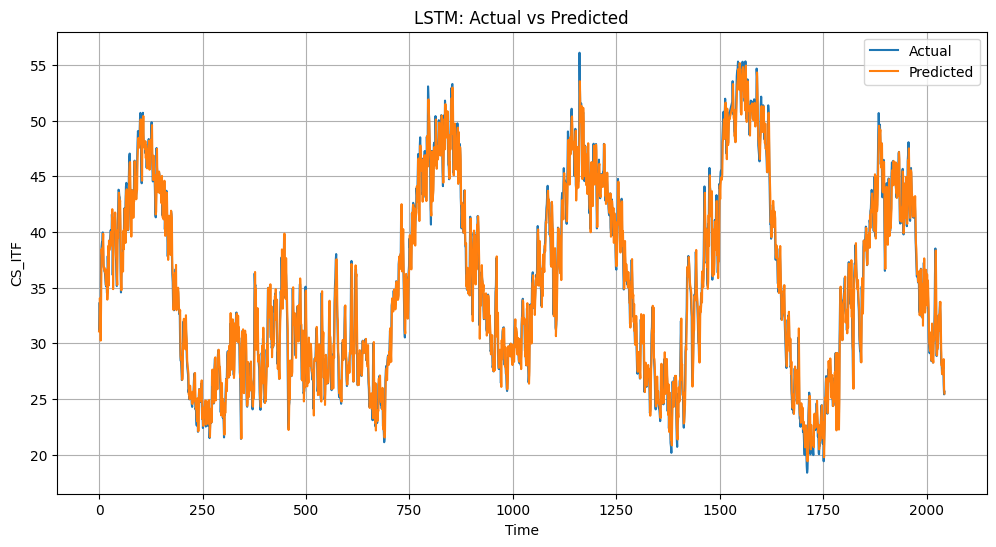

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('CS_ITF')
plt.legend()
plt.grid(True)
plt.show()